# Investigate changes in the Krill Growth Potential simulated by the CESM-LE

In [1]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import intake
import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Spin up dask cluster

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(36)
cluster

In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://128.117.181.225:35821 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Get the model grid for subsetting in latitude
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

Find the portion of the domain that is south of 30°S.
Create a `slice` object corresponding to this region.

First, let's visualize the `TLAT` array.

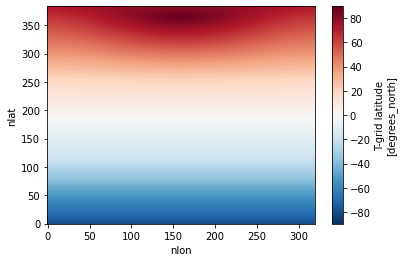

In [5]:
grid.TLAT.plot();

The model is a regular lat x lon grid in the southern hemisphere, this we can just use the first column of the `TLAT` array; all other columns are identical.

In [6]:
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
lat_slice

slice(0, 93, None)

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [7]:
catalog_file = './data/glade-cesm1-le.json'
col = intake.open_esm_datastore(catalog_file)
col

glade-cesm1-le-ESM Collection with 191066 entries:
	> 7 experiment(s)

	> 108 case(s)

	> 6 component(s)

	> 15 stream(s)

	> 1052 variable(s)

	> 116 date_range(s)

	> 40 member_id(s)

	> 191066 path(s)

	> 6 ctrl_branch_year(s)

	> 4 ctrl_experiment(s)

	> 41 ctrl_member_id(s)

Now we will search the collection for the ensemble members (unique `member_id`'s) that have a chlorophyll field. This is necessary because the ocean biogeochemistry was corrupted in some members and the data deleted.

In this cell, `member_id` is a list of the ensemble members we want to operate on.

In [8]:
col_sub = col.search(experiment=['20C'],                      
                     stream='pop.h', 
                     variable=['diatChl'])

member_id = list(col_sub.df.member_id.unique())
print(member_id)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 101, 102, 103, 104, 105]


## Now let's search for the data we want

Specify a list of variables and perform a search. Under the hood, the `search` functionality uses [`pandas`](https://pandas.pydata.org/) data frames. We can view that frame here using the `.df` syntax.

In [9]:
variables = ['SST', 'diatChl', 'spChl', 'diazChl', 'IFRAC']

col_sub = col.search(
    experiment=['20C', 'RCP85'], 
    stream='pop.h', 
    variable=['SST', 'diatChl', 'spChl', 'diazChl'],
    member_id=member_id[0:3],
    )

print(col_sub)

col_sub.df.head()

glade-cesm1-le-ESM Collection with 36 entries:
	> 2 experiment(s)

	> 6 case(s)

	> 1 component(s)

	> 1 stream(s)

	> 4 variable(s)

	> 4 date_range(s)

	> 3 member_id(s)

	> 36 path(s)

	> 3 ctrl_branch_year(s)

	> 2 ctrl_experiment(s)

	> 3 ctrl_member_id(s)



,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year,ctrl_experiment,ctrl_member_id
0,20C,b.e11.B20TRC5CNBDRD.f09_g16.001,ocn,pop.h,SST,185001-200512,1,/glade/campaign/cesm/collections/cesmLE/CESM-C...,402,CTRL,1
1,20C,b.e11.B20TRC5CNBDRD.f09_g16.002,ocn,pop.h,SST,192001-200512,2,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
2,20C,b.e11.B20TRC5CNBDRD.f09_g16.009,ocn,pop.h,SST,192001-200512,9,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
3,RCP85,b.e11.BRCP85C5CNBDRD.f09_g16.001,ocn,pop.h,SST,200601-208012,1,/glade/campaign/cesm/collections/cesmLE/CESM-C...,2006,20C,1
4,RCP85,b.e11.BRCP85C5CNBDRD.f09_g16.001,ocn,pop.h,SST,208101-210012,1,/glade/campaign/cesm/collections/cesmLE/CESM-C...,2006,20C,1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- drop the singleton dimension on SST (which screws up coordinate alignment)

In [12]:
def fix_sst_time_and_subset(ds):
    """Fix some things in the dataset and subset in space"""   
    grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']
    if 'SST' in ds:
        ds['SST'] = ds.SST.isel(z_t=0, drop=True)

    ds['time'] = xr.DataArray(cftime.num2date(ds.time_bound.mean(dim='d2'), units=ds.time.units, 
                                             calendar=ds.time.calendar), dims=('time'))
    
    data_vars = list(filter(lambda v: v in variables, ds.data_vars))
    
    ds = ds[data_vars+grid_vars].isel(nlat=lat_slice)
    
    # set grid variables to coordinates to ease concatenation in intake-esm
    new_coords = set(grid_vars) - set(ds.coords)

    return ds.set_coords(new_coords)

In [13]:
%%time
dsets = col_sub.to_dataset_dict(cdf_kwargs={'chunks': {'time': 60}, 'decode_times': False},
                                preprocess=fix_sst_time_and_subset)
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
                
--> There is/are 2 group(s)


AttributeError: 'FSMap' object has no attribute 'tell'

tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='jupyterhub.ucar.edu', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/bokeh/server/views/ws.py", line 123, in open
    raise ProtocolError("Subprotocol header is not 'bokeh'")
bokeh.protocol.exceptions.ProtocolError: Subprotocol header is not 'bokeh'


Now, let's compute the total surface chlorophyll concentration:

In [ ]:
def compute_chl_surf(ds):
    """compute surface chl"""

    ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
    ds.Chl_surf.attrs = ds.diatChl.attrs
    ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

    return ds.drop(['diatChl', 'spChl', 'diazChl'])

In [ ]:
dsets = {key: compute_chl_surf(ds) for key, ds in dsets.items()}
dsets

Concatenate the datasets in time, i.e. 20C + RCP8.5 experiments.

In [11]:
ds = xr.concat([dsets['ocn.20C.pop.h'], dsets['ocn.RCP85.pop.h']], dim='time', data_vars='minimal')
ds

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 3, nlat: 93, nlon: 320, time: 4044, z_t: 60, z_t_150m: 15)
Coordinates:
  * member_id   (member_id) int64 1 2 9
  * z_t         (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * time        (time) object 1850-01-17 00:30:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    dz          (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    SST         (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    Chl_surf    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 93, 320), meta=np.ndarray>
    time_bound  (time, d2) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
Attributes:
    source:                    CCSM POP2, the CCSM Ocean Component
    start_time:                This dataset was created on 2013-05-24 at 14:5...
    NCO:                       4.3.4
    cell_methods:              cell_methods = time: mean ==> the variable val...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Wed Nov 13 13:10:02 2013: ncrename -v TEMP,SST...
    tavg_sum_qflux:            2592000.0
    tavg_sum:                  2592000.0
    calendar:                  All years have exactly  365 days.
    nco_openmp_thread_number:  1
    title:                     b.e11.B20TRC5CNBDRD.f09_g16.001
    nsteps_total:              750

In [12]:
viable_habitat = (-1 <= ds.SST) & (ds.SST <= 5.)
viable_habitat.name = 'viable_habitat'
viable_habitat

<xarray.DataArray 'viable_habitat' (member_id: 3, time: 4044, nlat: 93, nlon: 320)>
dask.array<and_, shape=(3, 4044, 93, 320), dtype=bool, chunksize=(1, 60, 93, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) int64 1 2 9
  * time       (time) object 1850-01-17 00:30:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nlat, nlon

In [55]:
def compute_kgp(sst, chl, length):
    
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = 0.0101
    
    length_term = a + (b * length) + (c * length**2)
    
    chl = chl.where(chl >= 0.5).fillna(0.)
    chl_term = d * (chl / e + chl)
    
    sst_term = f * sst + g * sst**2
    
    kgp = length_term + chl_term + sst_term
    kgp.name = 'KGP'
    kgp = kgp.assign_coords({'length': length})
    return kgp

In [56]:
length = xr.DataArray([20., 40., 60.], dims=('length'))
length

<xarray.DataArray (length: 3)>
array([20., 40., 60.])
Dimensions without coordinates: length

In [57]:
kgp = compute_kgp(ds.SST, ds.Chl_surf, length)
kgp = kgp.assign_coords({'TLONG': ds.TLONG, 'TLAT': ds.TLAT})
kgp = kgp.to_dataset()
kgp

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 3, nlat: 93, nlon: 320, time: 4044)
Coordinates:
  * member_id  (member_id) int64 1 2 9
  * time       (time) object 1850-01-17 00:30:00 ... 2100-12-16 12:00:00
  * length     (length) float64 20.0 40.0 60.0
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
Dimensions without coordinates: nlat, nlon
Data variables:
    KGP        (length, member_id, time, nlat, nlon) float64 dask.array<chunksize=(3, 1, 60, 93, 320), meta=np.ndarray>

In [47]:
dsp = util.pop_add_cyclic()
dsp

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 3, nlat: 93, nlon: 321, time: 4044)
Coordinates:
  * member_id  (member_id) int64 1 2 9
  * time       (time) object 1850-01-17 00:30:00 ... 2100-12-16 12:00:00
  * length     (length) float64 20.0 40.0 60.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG      (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    kgp        (length, member_id, time, nlat, nlon) float64 dask.array<chunksize=(3, 1, 60, 93, 161), meta=np.ndarray>

In [49]:
%%time
lon, lat = dsp.TLONG, dsp.TLAT
field = dsp['KGP'].sel(length=40.).isel(time=0).mean('member_id').compute()
field

CPU times: user 506 ms, sys: 56 ms, total: 561 ms
Wall time: 15.3 s


<xarray.DataArray 'kgp' (nlat: 93, nlon: 321)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     object 1850-01-17 00:30:00
    length   float64 40.0
Dimensions without coordinates: nlat, nlon

[Text(0.5, 1.0, 'Krill  growth potential')]

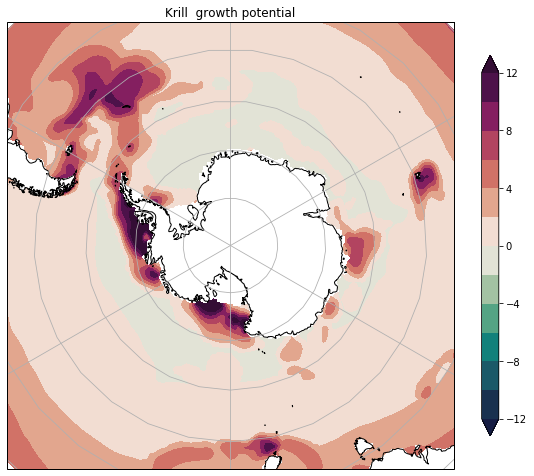

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -90,  -45], crs=ccrs.PlateCarree())


cmap = cmocean.cm.curl
levels = np.arange(-12., 14., 2.)

cf = ax.contourf(lon, lat, field,
                 cmap=cmap,
                 extend='both',
                 levels=levels,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()
plt.colorbar(cf, shrink=0.7)

ax.set(title='Krill  growth potential')